<a href="https://colab.research.google.com/github/rdemarqui/sentiment_analysis/blob/main/02%20Vectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

# Vectorization
---

In [252]:
seed_value = 42

In [253]:
import multiprocessing, os
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn import metrics
from lightgbm import LGBMClassifier
import numpy as np
np.random.seed(seed_value)

In [254]:
path = os.getcwd()
path

'/content'

In [255]:
cores = multiprocessing.cpu_count()
cores

2

In [256]:
def vector_method_score(X_train, y_train, X_test, y_test, n_splits=5, shuffle=True, scoring='roc_auc'):
  # Check cross-validation score
  kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=seed_value)
  model = LGBMClassifier(n_jobs=-1, verbose=-1, random_state=seed_value)
  scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  cv_score = np.round(scores, 5)

  # Check test score
  model.fit(X_train, y_train);
  y_pred = model.predict_proba(X_test)[:,1]
  test_score = np.round(metrics.roc_auc_score(y_test, y_pred), 5)

  return cv_score, test_score

In [257]:
def pipeline(X_train, y_train, X_test, y_test, vect_function, **kwargs):
  dict_csv_score = {}
  dict_test_score = {}
  for preproc_method in X_train.columns:
    print(preproc_method)
    X_train_vec, X_test_vec = vect_function(X_train[preproc_method], X_test[preproc_method])
    cv_score, test_score = vector_method_score(X_train_vec, y_train, X_test_vec, y_test)

    dict_csv_score[preproc_method] = cv_score
    dict_test_score[preproc_method] = [test_score]

  return dict_csv_score, dict_test_score

## Dataset
---

In [258]:
import pandas as pd
from sklearn.model_selection import train_test_split
from itertools import chain

In [259]:
try:
  df = pd.read_csv(os.path.join(path, 'data\preprocessed_corpus.zip'),
                   sep=',', compression='zip')
except:
  !wget https://github.com/rdemarqui/sentiment_analysis/raw/main/data/preprocessed_corpus.zip -q
  df = pd.read_csv(os.path.join(path, 'preprocessed_corpus.zip'),
                   sep=',', compression='zip')

In [260]:
columns = ['review_text_clean', 'review_text_clean_stop', 'review_text_clean_stem',
           'review_text_clean_stop_stem', 'review_text_clean_lemma', 'review_text_clean_stop_lemma',
           'overall_rating']
corpus = df[columns].copy()
corpus['overall_rating'] = corpus['overall_rating'].apply(lambda x: 1 if x >= 4 else 0)
corpus = corpus.dropna()
print(corpus.shape)

(113005, 7)


In [261]:
X_train, X_test, y_train, y_test = train_test_split(corpus.iloc[:, :-1], corpus.iloc[:, -1:],
                                                    test_size=0.2, random_state=seed_value)

In [262]:
X_train.head()

,review_text_clean,review_text_clean_stop,review_text_clean_stem,review_text_clean_stop_stem,review_text_clean_lemma,review_text_clean_stop_lemma
77662,adorei produto muito pratico serviu ao propros...,adorei produto pratico serviu proprosito prome...,ador produt muit pra serv ao proprosit promet,ador produt pra serv proprosit promet,adorar produto muito pratico servir a o propro...,adorar produto pratico servir proprosito prometer
78184,meu produto veio danificado porem nao sera mot...,produto veio danificado porem motivo devolucao...,meu produt vei danific por nao ser motiv par d...,produt vei danific por motiv devoluca obrig,meu produto vir danificar porem nao sera motiv...,produto vir danificar porem motivo devolucao o...
105690,otimo produto travesseiro maravilhoso quantida...,otimo produto travesseiro maravilhoso quantida...,otim produt travess maravilh quant muit boa de...,otim produt travess maravilh quant boa pen gan...,otimo produto travesseiro maravilhoso quantida...,otimo produto travesseiro maravilhoso quantida...
96751,otima aquisicao agua geladinha fresca designer...,otima aquisicao agua geladinha fresca designer...,otim aquisica agu gel fresc design bonit ador ...,otim aquisica agu gel fresc design bonit ador ...,otimo aquisicao aguo geladinho fresco designer...,otimo aquisicao aguo geladinho fresco designer...
49691,produto atende corresponde as especificacoes s...,produto atende corresponde especificacoes cont...,produt atend correspond as especificaco sem co...,produt atend correspond especificaco cont pen ...,produto atender corresponder o especificacoe s...,produto atender corresponder especificacoes co...


In [263]:
# Checking y proportion
print(f'Train proportion\n{y_train.value_counts()/y_train.shape[0]}')

Train proportion
overall_rating
1                 0.700323
0                 0.299677
dtype: float64


In [264]:
X_train = X_train.astype(str)
y_train = y_train.values.ravel()
X_test = X_test.astype(str)
y_test = y_test.values.ravel()

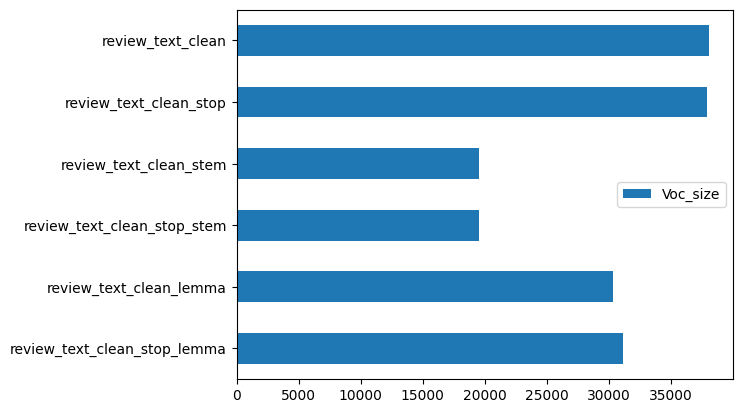

In [265]:
# Check Vocabulary size
voc_size = {}
for column in X_train.columns:
  full_text = ' '.join(X_train[column].tolist())
  words = full_text.split()
  vocabulary = set(words)
  voc_size[column] = len(vocabulary)

df_vocabulary_size = pd.DataFrame(list(voc_size.items()), columns=['Corpus', 'Voc_size'])
ax = df_vocabulary_size.plot.barh()
ax.set_yticklabels(df_vocabulary_size.Corpus)
ax.invert_yaxis();

## Sparse
---

### Bag of Word
___

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def apply_bag_of_word(X_train, X_test):
  vectorizer = CountVectorizer(lowercase=False, dtype=np.float32)
  X_train_vec = vectorizer.fit_transform(X_train)
  X_test_vec = vectorizer.transform(X_test)

  return X_train_vec, X_test_vec

In [ ]:
cv_score_bow, test_score_bow = pipeline(X_train, y_train, X_test, y_test, apply_bag_of_word)

review_text_clean
review_text_clean_stop
review_text_clean_stem
review_text_clean_stop_stem
review_text_clean_lemma
review_text_clean_stop_lemma


In [ ]:
df_cv_score_bow = pd.DataFrame(cv_score_bow).T
df_cv_score_bow['mean'] = df_cv_score_bow.mean(axis=1)
df_cv_score_bow

,0,1,2,3,4,mean
review_text_clean,0.97689,0.97546,0.97560,0.97598,0.97731,0.976248
review_text_clean_stop,0.96859,0.96726,0.96753,0.96885,0.96975,0.968396
review_text_clean_stem,0.97791,0.97608,0.97669,0.97667,0.97777,0.977024
review_text_clean_stop_stem,0.97023,0.96817,0.96931,0.97071,0.97059,0.969802
review_text_clean_lemma,0.97686,0.97540,0.97607,0.97643,0.97746,0.976444
review_text_clean_stop_lemma,0.96857,0.96640,0.96837,0.96992,0.96926,0.968504


### TF-IDF
---

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def apply_tf_idf(X_train, X_test):
  vectorizer = TfidfVectorizer(lowercase=False, dtype=np.float32)
  X_train_vec = vectorizer.fit_transform(X_train)
  X_test_vec = vectorizer.transform(X_test)

  return X_train_vec, X_test_vec

In [ ]:
cv_score_tfidf, test_score_tfidf = pipeline(X_train, y_train, X_test, y_test, apply_tf_idf)

review_text_clean
review_text_clean_stop
review_text_clean_stem
review_text_clean_stop_stem
review_text_clean_lemma
review_text_clean_stop_lemma


In [ ]:
df_cv_score_tfidf = pd.DataFrame(cv_score_tfidf).T
df_cv_score_tfidf['mean'] = df_cv_score_tfidf.mean(axis=1)
df_cv_score_tfidf

,0,1,2,3,4,mean
review_text_clean,0.97712,0.97555,0.97601,0.97601,0.97701,0.976340
review_text_clean_stop,0.96986,0.96756,0.96857,0.96916,0.97004,0.969038
review_text_clean_stem,0.97829,0.97630,0.97701,0.97649,0.97738,0.977094
review_text_clean_stop_stem,0.97148,0.96894,0.97034,0.97109,0.97077,0.970524
review_text_clean_lemma,0.97779,0.97550,0.97651,0.97643,0.97744,0.976734
review_text_clean_stop_lemma,0.96970,0.96726,0.96915,0.96978,0.96923,0.969024


## Dense
___

### Word2vec
___

In [156]:
from gensim.models import Word2Vec

In [216]:
def apply_word2vec(X_train, X_test, sg=0):
  X_train_tokenized = [text.split() for text in X_train.values.tolist()]
  X_test_tokenized = [text.split() for text in X_test.values.tolist()]

  vectorizer = Word2Vec(vector_size=300, sg=sg, workers=cores)
  vectorizer.build_vocab(X_train_tokenized)
  vectorizer.train(X_train_tokenized, total_examples=vectorizer.corpus_count, epochs=1, report_delay=1)

  # A random vector for OOV it's better than zeros vector, because model can learn something
  vector_shape = vectorizer.wv[list(vectorizer.wv.key_to_index)[0]].shape
  np.random.seed(seed_value)
  UNK_TOKEN = np.random.rand(*vector_shape)

  def get_word_vector(word):
    return vectorizer.wv[word] if word in vectorizer.wv else UNK_TOKEN

  X_train_vec = [[get_word_vector(word) for word in text] for text in X_train_tokenized]
  X_test_vec = [[get_word_vector(word) for word in text] for text in X_test_tokenized]

  # Get mean of word vectors for each text
  X_train_vec = [np.mean(np.array(vector).T, axis=1) for vector in X_train_vec]
  X_test_vec = [np.mean(np.array(vector).T, axis=1) for vector in X_test_vec]

  return X_train_vec, X_test_vec

#### CBOW - Continuous Bag of Words
___

In [ ]:
cv_score_cbow, test_score_cbow = pipeline(X_train, y_train, X_test, y_test, apply_word2vec, sg=0)

In [219]:
df_cv_score_cbow = pd.DataFrame(cv_score_cbow).T
df_cv_score_cbow['mean'] = df_cv_score_cbow.mean(axis=1)
df_cv_score_cbow

,0,1,2,3,4,mean
review_text_clean,0.95935,0.96163,0.96179,0.96214,0.96326,0.961634
review_text_clean_stop,0.95393,0.95202,0.95238,0.95323,0.95441,0.953194
review_text_clean_stem,0.96474,0.96563,0.96651,0.96676,0.96808,0.966344
review_text_clean_stop_stem,0.96103,0.95927,0.95906,0.95979,0.96110,0.960050
review_text_clean_lemma,0.96569,0.96594,0.96696,0.96704,0.96848,0.966822
review_text_clean_stop_lemma,0.95762,0.95566,0.95589,0.95711,0.95915,0.957086


#### SG - Skip-Gram
___

In [235]:
cv_score_skgram, test_score_skgram = pipeline(X_train, y_train, X_test, y_test, apply_word2vec, sg=1)

review_text_clean
review_text_clean_stop
review_text_clean_stem
review_text_clean_stop_stem
review_text_clean_lemma
review_text_clean_stop_lemma


In [236]:
df_cv_score_skgram = pd.DataFrame(cv_score_skgram).T
df_cv_score_skgram['mean'] = df_cv_score_skgram.mean(axis=1)
df_cv_score_skgram

,0,1,2,3,4,mean
review_text_clean,0.95959,0.96192,0.96134,0.96232,0.96350,0.961734
review_text_clean_stop,0.95327,0.95179,0.95244,0.95345,0.95423,0.953036
review_text_clean_stem,0.96488,0.96590,0.96648,0.96728,0.96869,0.966646
review_text_clean_stop_stem,0.96074,0.95882,0.95897,0.95962,0.96123,0.959876
review_text_clean_lemma,0.96513,0.96548,0.96665,0.96690,0.96820,0.966472
review_text_clean_stop_lemma,0.95783,0.95509,0.95526,0.95574,0.95849,0.956482


### FastText
___

In [237]:
from gensim.models import FastText

In [267]:
def apply_FastText(X_train, X_test):
  X_train_tokenized = [text.split() for text in X_train.values.tolist()]
  X_test_tokenized = [text.split() for text in X_test.values.tolist()]

  vectorizer = FastText(vector_size=300, workers=cores)
  vectorizer.build_vocab(X_train_tokenized)
  vectorizer.train(X_train_tokenized, total_examples=vectorizer.corpus_count, epochs=1, report_delay=1)

  # A random vector for OOV it's better than zeros vector, because model can learn something
  vector_shape = vectorizer.wv[list(vectorizer.wv.key_to_index)[0]].shape
  np.random.seed(seed_value)
  UNK_TOKEN = np.random.rand(*vector_shape)

  def get_word_vector(word):
    return vectorizer.wv[word] if word in vectorizer.wv else UNK_TOKEN

  X_train_vec = [[get_word_vector(word) for word in text] for text in X_train_tokenized]
  X_test_vec = [[get_word_vector(word) for word in text] for text in X_test_tokenized]

  # Get mean of word vectors for each text
  X_train_vec = [np.mean(np.array(vector).T, axis=1) for vector in X_train_vec]
  X_test_vec = [np.mean(np.array(vector).T, axis=1) for vector in X_test_vec]

  return X_train_vec, X_test_vec

In [268]:
cv_score_FastTest, test_score_FastTest = pipeline(X_train, y_train, X_test, y_test, apply_FastText)

review_text_clean
review_text_clean_stop
review_text_clean_stem
review_text_clean_stop_stem
review_text_clean_lemma
review_text_clean_stop_lemma


In [269]:
cv_score_FastTest = pd.DataFrame(cv_score_FastTest).T
cv_score_FastTest['mean'] = cv_score_FastTest.mean(axis=1)
cv_score_FastTest

,0,1,2,3,4,mean
review_text_clean,0.95435,0.95478,0.95569,0.95581,0.95713,0.955552
review_text_clean_stop,0.95083,0.94812,0.94987,0.94853,0.95110,0.949690
review_text_clean_stem,0.95727,0.95712,0.95849,0.95875,0.95927,0.958180
review_text_clean_stop_stem,0.95525,0.95170,0.95397,0.95302,0.95517,0.953822
review_text_clean_lemma,0.95779,0.95730,0.95887,0.95953,0.96155,0.959008
review_text_clean_stop_lemma,0.95106,0.94732,0.94908,0.94871,0.95138,0.949510


### Doc2Vec
___

* https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
* https://aitechtrend.com/doc2vec-made-easy-a-step-by-step-guide-to-gensim-implementation/

In [ ]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from nltk.tokenize import word_tokenize

In [ ]:
X = corpus.values.tolist()
X = list(chain.from_iterable(X))

tagged_docs = [TaggedDocument(words=word_tokenize(doc), tags=[str(i)]) for i, doc in enumerate(X)]
tagged_docs[:4]

#### DBOW - Distributed Bag of Words
___

In [ ]:
d2v_dbow = Doc2Vec(dm=0,
                   vector_size=300,
                   negative=5,
                   hs=0,
                   min_count=2,
                   sample=0,
                   workers=cores)

In [ ]:
d2v_dbow.build_vocab(tagged_docs)

In [ ]:
d2v_dbow.train(tagged_docs, total_examples=d2v_dbow.corpus_count, epochs=50)

In [ ]:
similarity = 1 - cosine(d2v_dbow.infer_vector(word_tokenize(X[1])),
                        d2v_dbow.infer_vector(word_tokenize(X[3])))
similarity

#### DM - Distributed Memory
___

In [ ]:
# 0.025
d2v_dm = Doc2Vec(dm=1,
                 vector_size=300,
                 negative=5,
                 hs=0,
                 min_count=2,
                 sample=0,
                 workers=cores)

In [ ]:
d2v_dm.build_vocab(tagged_docs)

In [ ]:
d2v_dm.train(tagged_docs, total_examples=d2v_dm.corpus_count, epochs=50)

In [ ]:
similarity = 1 - cosine(d2v_dm.infer_vector(word_tokenize(X[1])),
                        d2v_dm.infer_vector(word_tokenize(X[3])))
similarity

#### Concatenated
___

In [ ]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

In [ ]:
d2v_combined = ConcatenatedDoc2Vec([d2v_dbow, d2v_dm])

In [ ]:
similarity = 1 - cosine(d2v_combined.infer_vector(word_tokenize(X[1])),
                        d2v_combined.infer_vector(word_tokenize(X[3])))
similarity

### Transformers
___

* https://huggingface.co/models?pipeline_tag=sentence-similarity&language=pt&sort=trending
* https://huggingface.co/blog/how-to-train-sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

In [ ]:
# https://www.sbert.net/

In [ ]:
X = corpus.values.tolist()
X = list(chain.from_iterable(X))
X[0:2]

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
#model = SentenceTransformer('Legal-BERTimbau-sts-large-ma-v3')

In [ ]:
#Sentences are encoded by calling model.encode()
embeddings = model.encode(X)

In [ ]:
embeddings[0].shape

In [ ]:
similarity = 1 - cosine(embeddings[1],
                        embeddings[3])
similarity

## References

* http://hunterheidenreich.com/blog/intro-to-word-embeddings/